**THIS TIME SERIES ANALYSIS IS DONE  ON CLOSING PRICE OF Historical S&P 500 index DATASET. FROM 2023 to 2025.**

Throughout the entire notebook we will focus on identifying trends , seasonal patterns and variance changes. 
if the data is non stationary inherently we will also try to convert the data from non stationary to stationary


THe analysis is done on the log returns column on the closing prices 
While dealing with financial data this is standard practice to analyze the log return column rather than the raw price series.***

In [1]:
#import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#BEgin with loading the dataset using yfinance library.

import yfinance as yf
import pandas as pd

#Download S&P 500 data
sp500 = yf.download('^GSPC', start='2023-01-01', end='2025-05-23')
sp500_df = sp500[['Close']].copy()

#Move date from index to column
sp500_df.reset_index(inplace=True)  
sp500_df.columns = ['Date', 'Closing_Price']

# Convert date again to index 
sp500_df.set_index('Date', inplace=True)
sp500_df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Closing_Price
Date,
2023-01-03,3824.139893
2023-01-04,3852.969971
2023-01-05,3808.100098
2023-01-06,3895.080078
2023-01-09,3892.090088
...,...
2025-05-16,5958.379883
2025-05-19,5963.600098
2025-05-20,5940.459961


In [3]:
sp500_df.shape

(599, 1)

In [4]:
sp500_df.describe() 

,Closing_Price
count,599.000000
mean,5004.822421
std,690.817364
min,3808.100098
25%,4373.415039
50%,5070.549805
75%,5623.324951
max,6144.149902


In [5]:
sp500_df.isnull().sum()

Closing_Price    0
dtype: int64

In [6]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 599 entries, 2023-01-03 to 2025-05-22
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Closing_Price  599 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


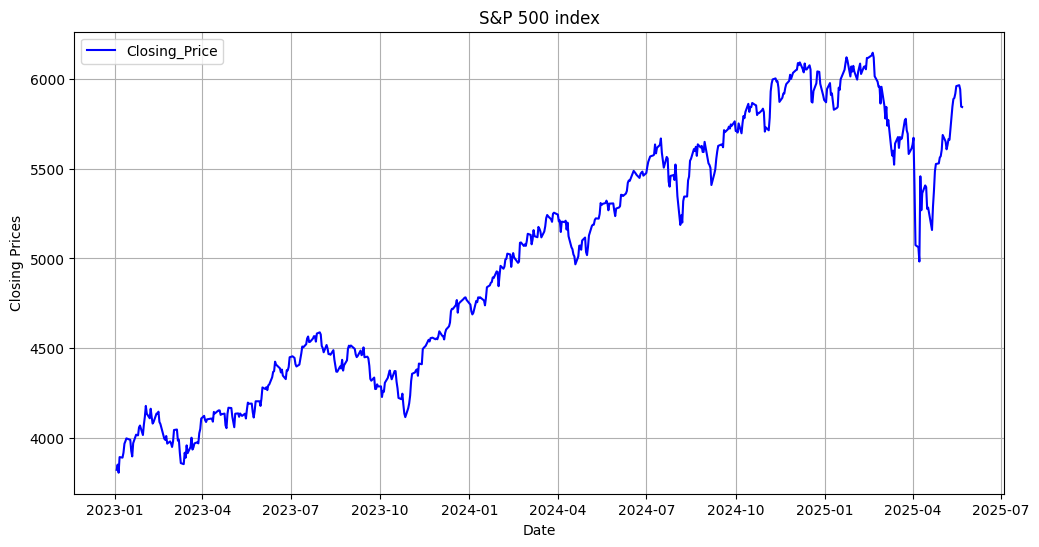

In [3]:
#Lets have a look at the graph Date vs closing Price

def plot_timeseries(df:pd.DataFrame,x_label,y_label,col):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[col], label=col, color="blue")
    plt.title("S&P 500 index")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.show()
plot_timeseries(sp500_df,"Date","Closing Prices","Closing_Price")




**Observation:** 
- There is no visually obvious repeating pattern at regular intervals (such as yearly, quarterly, or monthly cycles) that could indicate strong seasonality.
,any seasonality is not pronounced. 
- The dominant feature  however is the trend, 
with some volatility and irregular cycles, rather than a clear seasonal component.
- From simply eyeballing its is evdient the seresi is not statonary

## Now we are going to perform seasonal decomposition.

### Things to Consider Before Seasonal Decomposition

- **Model Selection**
  - Decide whether an additive or multiplicative model is appropriate based on whether seasonal fluctuations remain constant (additive) or vary with the trend (multiplicative).

- **Identify Seasonality Period**
  - Use domain knowledge, plots, autocorrelation, or spectral analysis to determine the correct seasonal period.

- **Visual Inspection**
  - Plot time series to visually check for trends, seasonality, and anomalies before decomposition.

- **Choose the Right Decomposition Method**
  - Select a decomposition technique (classical, STL, etc.) suited to  data and analysis goals.

---

### Choosing the Right Seasonal Window

- **Too small a window:** Overfits noise, mistaking random fluctuations for seasonality.
- **Too large a window:** Oversmooths, missing real seasonal patterns and trend shifts.
- **Balance is key:** The window should be large enough to smooth out noise but small enough to capture genuine seasonality.


###  Techniques in Selecting an Appropriate Seasonal Window

- Use autocorrelation plots, periodograms, or Fourier transforms to identify dominant seasonal periods.
- Apply subsequence-based methods to capture local repetitive patterns.  
  *(Source: [AALTD22_paper_3876.pdf](https://project.inria.fr/aaltd22/files/2022/08/AALTD22_paper_3876.pdf


In [4]:
# lets begin with applying fourier transform , the Peaks in the frequency spectrum indicate dominant periodicities, which can be used to set the window size.
# first lets detrend the data to get more clarity since trend can mask periodic signals
test_sp500=sp500_df.copy()
test_sp500["Closing_Price"]=test_sp500["Closing_Price"].diff().dropna()
test_sp500=test_sp500.dropna()

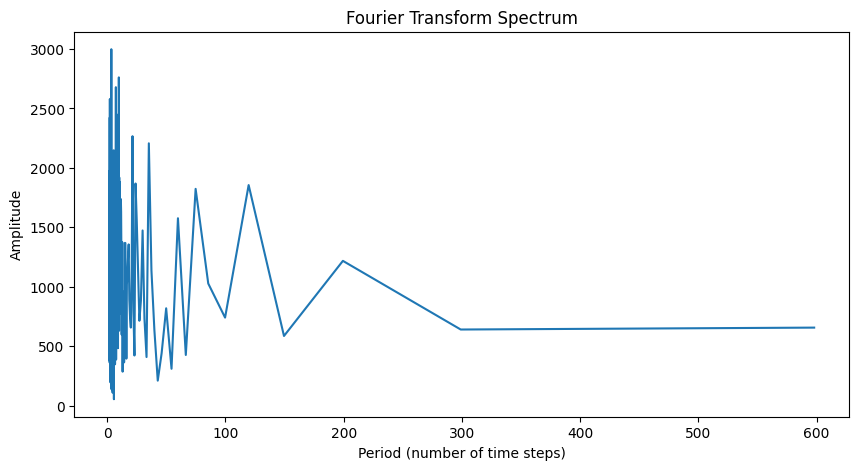

In [9]:
#The Fourier Transform decomposes your time series into a sum of sine and cosine waves of different frequencies. 
# The result is a spectrum showing which frequencies (periodicities) are most prominent.

import numpy as np
import matplotlib.pyplot as plt


data =test_sp500["Closing_Price"].values

# Compute the Fourier Transform
fft_vals = np.fft.fft(data)
fft_freq = np.fft.fftfreq(len(data))

# Only keep the positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_power = np.abs(fft_vals[pos_mask])

# Plot the spectrum
plt.figure(figsize=(10, 5))
plt.plot(1/fft_freq, fft_power)
plt.xlabel('Period (number of time steps)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform Spectrum')
plt.show() 

#The high amplitudes at low frequencies (first 50 points) mean your data has strong long-term trends or cycles. 
#The flatness at higher frequencies means there is little to no regular short-term seasonality or repeating patterns in your data after detrending.





C:\Users\injil\AppData\Local\Temp\ipykernel_8244\690317595.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs > 0, 1 / freqs, 0)


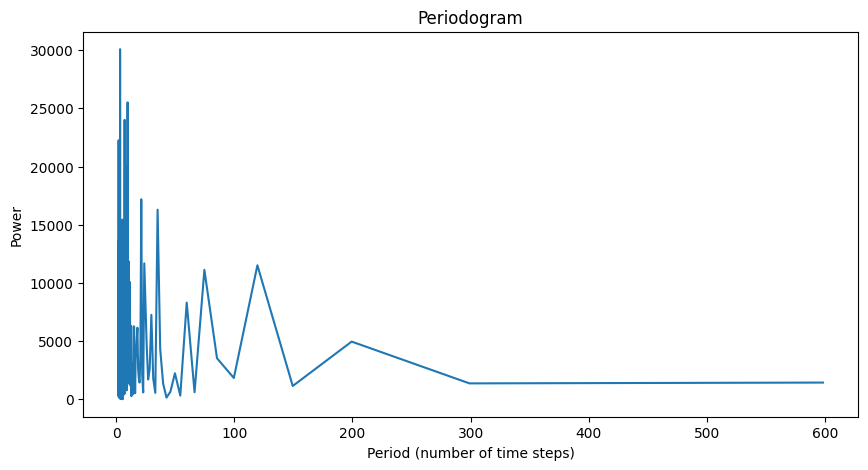

In [10]:
from scipy.signal import periodogram


fs = 1  # Sampling frequency (1 for regular time steps, adjust if needed)
freqs, power = periodogram(data, fs=fs)

# Convert frequency to period (avoid division by zero)
periods = np.where(freqs > 0, 1 / freqs, 0)

plt.figure(figsize=(10, 5))
plt.plot(periods[freqs > 0], power[freqs > 0])
plt.xlabel('Period (number of time steps)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()


#The periodogram does not show any distinct, sharp peaks at higher periods that would indicate a 
# dominant seasonal cycle. Most of the power is concentrated at very low periods (high frequencies), 
# which typically reflects short-term fluctuations or noise, not seasonality.




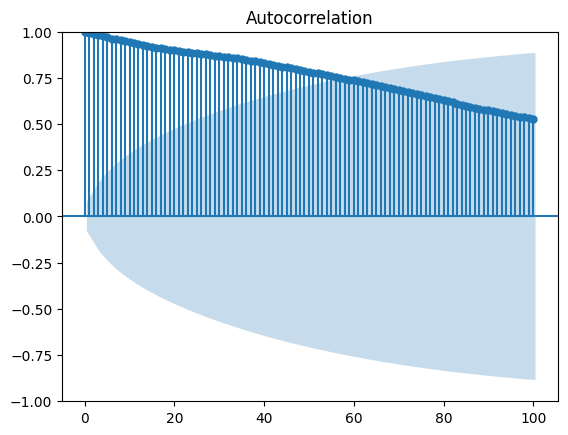

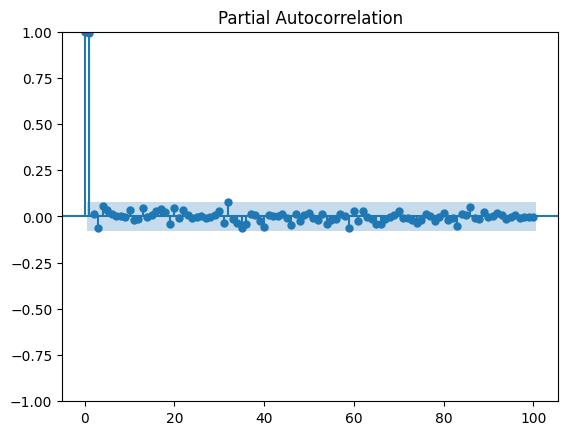

In [11]:

#Lets check the ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(df: pd.DataFrame):
            plot_acf(df["Closing_Price"].dropna(), lags=100)
            plot_pacf(df["Closing_Price"].dropna(), lags=100)
            plt.show()




plot_acf_pacf(sp500_df)



## Key Insights

- **No Clear Seasonality:**  
  The periodogram, ACF plot, and Fourier Transform spectrum all indicate a lack of strong or regular seasonality in the S&P 500 dataset.

- **Periodogram:**  
  No distinct peaks at higher periods; no dominant seasonal cycles detected.

- **ACF Plot:**  
  Gradual decay in autocorrelation, suggesting trend or persistence rather than repeating seasonal patterns.

- **Fourier Spectrum:**  
  Highest amplitudes at low periods (high frequencies), indicating short-term fluctuations, not seasonality.

**Conclusion:**  
There is no evidence to support a specific seasonal period for decomposition. The data is better characterized by trend and irregular fluctuations rather than seasonal cycles.
- the  above methods did not pass to determine seasonal period
- We can try out differnt period values and make the best guess.

 

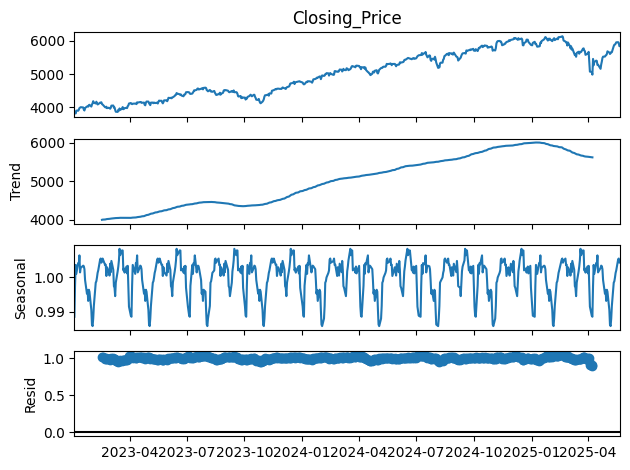

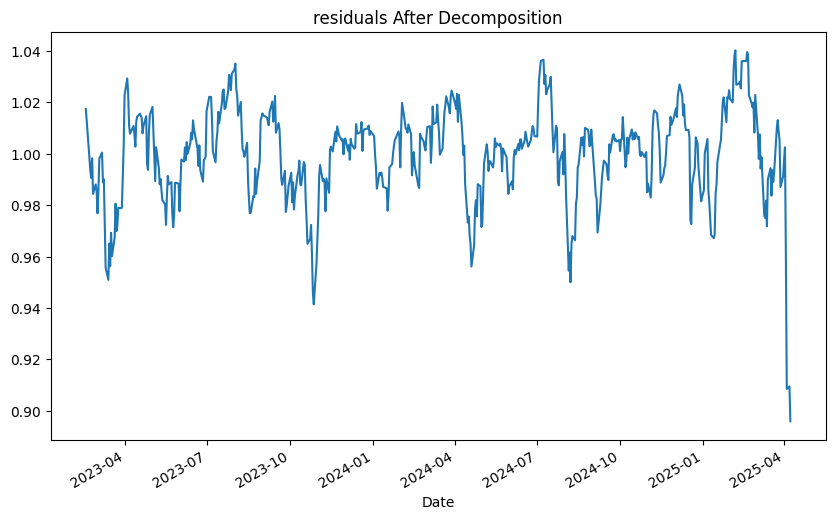

In [3]:

# Decompose the time series data
""" When dealing with a non-stationary time series, a decomposition is still possible.
 We can either perform a multiplicative decomposition on the original time series or make it suitable for an additive decomposition, 
 either by subtracting each value from its predecessor (differencing), transforming values into their logarithm (logging), or a combination of both. """

"""The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, 
or the variation around the trend-cycle, does not vary with the level of the time series. 
Note : The additive decompostion assumes data is stationary.

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be 
proportional to the level of the time series, then a multiplicative decomposition is more appropriate. 
"""


"""  
The residual can be formed by either subtracting out or dividing out the calculated trend and seasonality, 
depending on whether the target is assessed to have additive or multiplicative trend and seasonality respectively.
"""

def Seasonal_decompose(df:pd.DataFrame, model:str):
    
    result = seasonal_decompose(df["Closing_Price"], model=model, period=63) #63 is an assumption for a quarterly seasonality 
    result.plot()
    plt.show()
    trend= result.trend
    seasonal=result.seasonal
    residual = result.resid
    
   

    # Plot residuals
    residual.plot(figsize=(10, 6))
    plt.title("residuals After Decomposition")
    return trend, seasonal, residual
#We use multiplicative decompostion on raw data which is the best choice here since the data is not stationary
t,s,residual=Seasonal_decompose(sp500_df,"multiplicative")  
decomposition_results = {
    'Closing_Price': {
        'trend': t,
        'seasonal': s,
        'residual': residual
    }
}

 


- No to try out additive decompostion :
WE perform some transformation on original close columns and ccreate new column  using -> differencing, logging, logged differencing these new columns are actually stationary in mean which is acceptable for additive decomposition

In [4]:
# Perform differencing on the 'Close' prices
sp500_df['Close_Diff'] = sp500_df['Closing_Price'].diff().dropna()

# Log transformation before decomposition
sp500_df['Close_Log'] = np.log(sp500_df['Closing_Price'])

# Creating column with differenced logged prices
sp500_df['Close_Log_Diff'] = sp500_df['Closing_Price'].diff().dropna()


sp500_df= sp500_df.dropna()


In [5]:
# Perform the Augmented Dickey-Fuller test on each new price column
from statsmodels.tsa.stattools import adfuller
adf_summaries = []

for column in ['Close_Diff', 'Close_Log', 'Close_Log_Diff']:
    adf_result_diff = adfuller(sp500_df[column])

    # Create a summary of the test results for the differenced series
    adf_summary = {
        'Column': column, 
        'ADF Statistic': adf_result_diff[0],
        'p-value': adf_result_diff[1],
        'Critical Values': adf_result_diff[4]
    }
    
    adf_summaries.append(adf_summary)

adf_summaries

[{'Column': 'Close_Diff',
  'ADF Statistic': -13.991315654163891,
  'p-value': 4.0118016702657683e-26,
  'Critical Values': {'1%': -3.441406876071572,
   '5%': -2.866418015869717,
   '10%': -2.5693678601956718}},
 {'Column': 'Close_Log',
  'ADF Statistic': -1.277689121032,
  'p-value': 0.6393167602415635,
  'Critical Values': {'1%': -3.4414256033746606,
   '5%': -2.8664262627821473,
   '10%': -2.569372254520843}},
 {'Column': 'Close_Log_Diff',
  'ADF Statistic': -13.991315654163891,
  'p-value': 4.0118016702657683e-26,
  'Critical Values': {'1%': -3.441406876071572,
   '5%': -2.866418015869717,
   '10%': -2.5693678601956718}}]

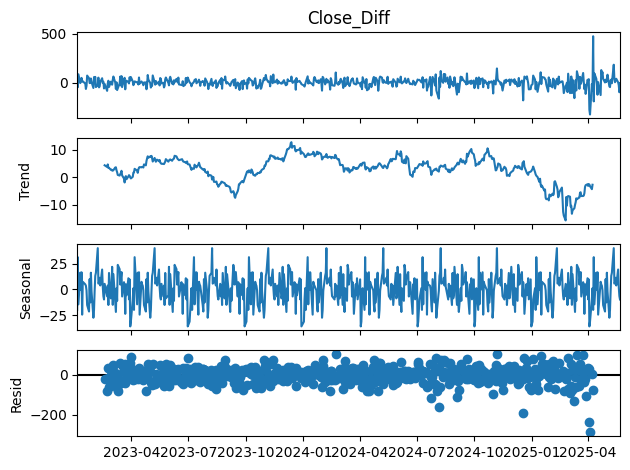

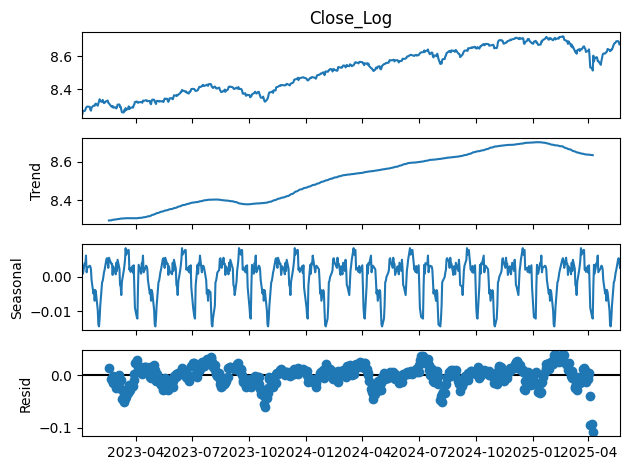

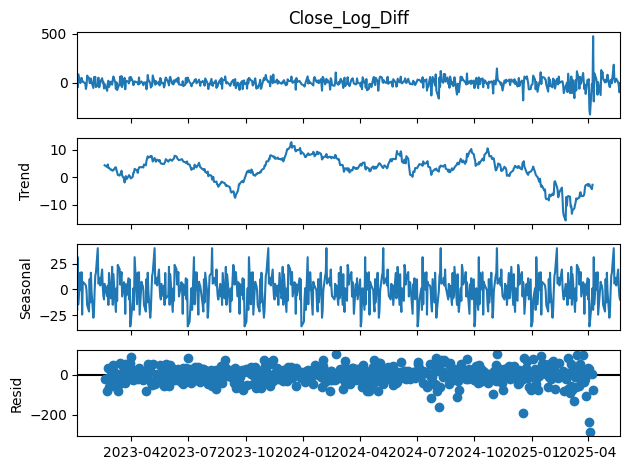

In [ ]:

columns_to_decompose = ['Close_Diff', 'Close_Log', 'Close_Log_Diff']


for column in columns_to_decompose:
    result = seasonal_decompose(sp500_df[column], model='additive', period=63)
    

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    
    
    decomposition_results[column] = {
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual
    }
    

    result.plot()
    plt.tight_layout()
    plt.show()

The multiplicative decomposition of the original time series and the additive decomposition of the logged-time series provide both a same trendline with almost a clear direction .
 Both differenced time series, however, fail to provide an easy-to-interpret trendline.

 We try to evaluate the quality of time series decomposition using Ljung-Box test  on residuals to check if they are autocorrelated (i.e., if there is remaining structure or "memory" in the residuals that the model did not capture)..

Shapiro-Wilk Test:
It applies the Shapiro-Wilk test to the residuals to check if they are normally distributed.



In [ ]:
# Dictionary to store the test results
test_results = {}

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox

"""
Ljung-Box Test
This test checks autocorrelation in the residuals.

Null hypothesis (H₀): No autocorrelation up to a certain lag.

High p-value (> 0.05): Fail to reject H₀ → residuals are not autocorrelated (good).

Low p-value (< 0.05): Reject H₀ → residuals are autocorrelated (bad for modeling)."""

# Shapiro-Wilk test
from scipy.stats import shapiro

"""Shapiro-Wilk Test
This test checks normality of the residuals.

Null hypothesis (H₀): Data is normally distributed.

High p-value (> 0.05): Fail to reject H₀ → residuals are normally distributed.

Low p-value (< 0.05): Reject H₀ → residuals not normally distributed.

"""



for column, components in decomposition_results.items():
    residuals = components['residual']
    
    #Ljung-Box Test on the residuals
    lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
    
    #Correlate the residuals to the  key name
    correlation = sp500_df[column].corr(residuals)
    
    #Shapiro-Wilk test on the residuals
    shapiro_test = shapiro(residuals.dropna())
    
    #Store results in the dictionary
    test_results[column] = {
        'ljung_box': lb_test,
        'correlation': correlation,
        'shapiro': shapiro_test
    }

In [ ]:
#Transform test_results into a DataFrame
test_results_df = pd.DataFrame({
    column: {
        'ljung_box_stat': test_results[column]['ljung_box']['lb_stat'].values[0],
        'ljung_box_pvalue': test_results[column]['ljung_box']['lb_pvalue'].values[0],
        'correlation': test_results[column]['correlation'],
        'shapiro_stat': test_results[column]['shapiro'][0],
        'shapiro_pvalue': test_results[column]['shapiro'][1]
    }
    for column in test_results
}).T


test_results_df

,ljung_box_stat,ljung_box_pvalue,correlation,shapiro_stat,shapiro_pvalue
Closing_Price,1312.299895,8.475226e-276,0.266423,0.950024,1.691999e-12
Close_Diff,8.793543,5.518029e-01,0.935768,0.940921,9.222413e-14
Close_Log,1286.296403,3.467555e-270,0.268349,0.942557,1.528223e-13
Close_Log_Diff,8.793543,5.518029e-01,0.935768,0.940921,9.222413e-14


## Residual Diagnostics Summary

### Multiplicative Decomposition
- **Strong autocorrelation** in residuals (Ljung-Box p ≈ 0)
- **Residuals are not normal** (Shapiro-Wilk p ≪ 0.05)

### Additive Decomposition
- **No significant autocorrelation** (Ljung-Box p > 0.05)
- **Residuals still not normal** (Shapiro-Wilk p ≪ 0.05)
- **Close_Log** shows unexpected autocorrelation—suggesting possible issues with this transformation or decomposition choice.

---

## Key Insights

- **Additive decomposition** is better, as it removes autocorrelation.
- **Normality remains an issue** for both methods.


- simple decomposition methods have some drawbacks.
-  First, using a moving average to estimate the Trend + Cycle creates missing values for the first few and last values of the series. 
- There are more robust methods like Seasonal and Trend decomposition using Loess - STL - that addresses some of these problems.



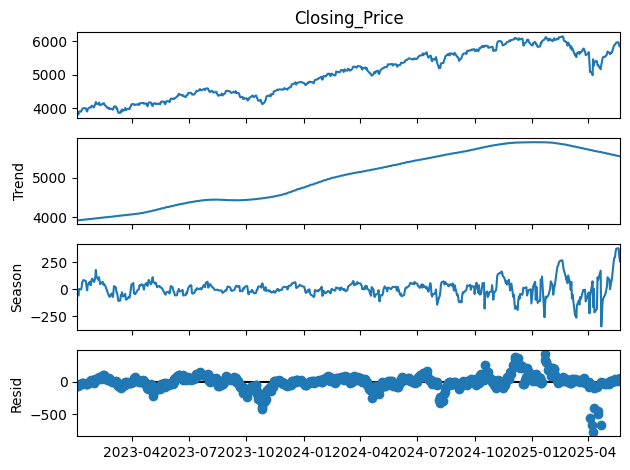

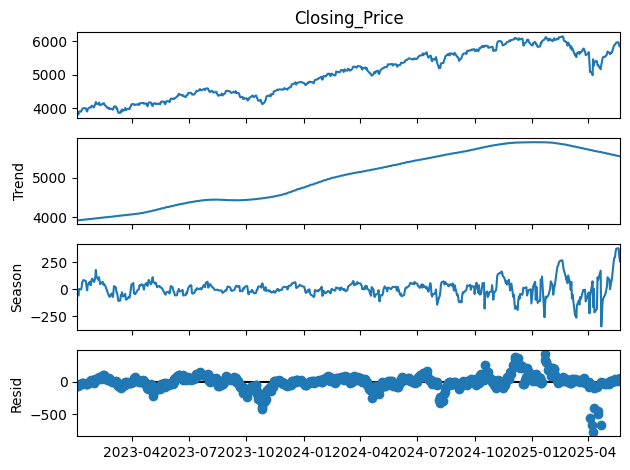

In [14]:




from statsmodels.tsa.seasonal import STL
stl = STL(sp500_df["Closing_Price"], period=63, robust=True)
res = stl.fit()
res.plot()


Text(0.5, 1.0, 'Residual Component')

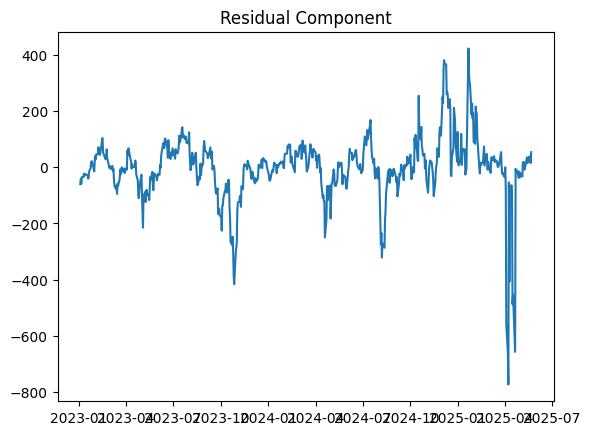

In [15]:
plt.plot(res.resid)
plt.title('Residual Component')
# the overly positve and negative residuals at the end suggest model overestimated  
# and underestimated some values at the end 

##  Residual Analysis Summary 



### 1. Heteroscedasticity


- Residual variance increases significantly over time.
- Early series: stable fluctuations.
- Later series (around 2025): large swings (e.g., +400 to -800).

**Conclusion**: Non-constant variance detected — classical models (like ARIMA) assumptions violated. 

---

### 2. Residual Pattern
- Residuals show persistent structure and clustering.
- Suggests non-randomness; possible autocorrelation.

**Conclusion**: Residuals are not white noise — trend/seasonality may not be fully captured.





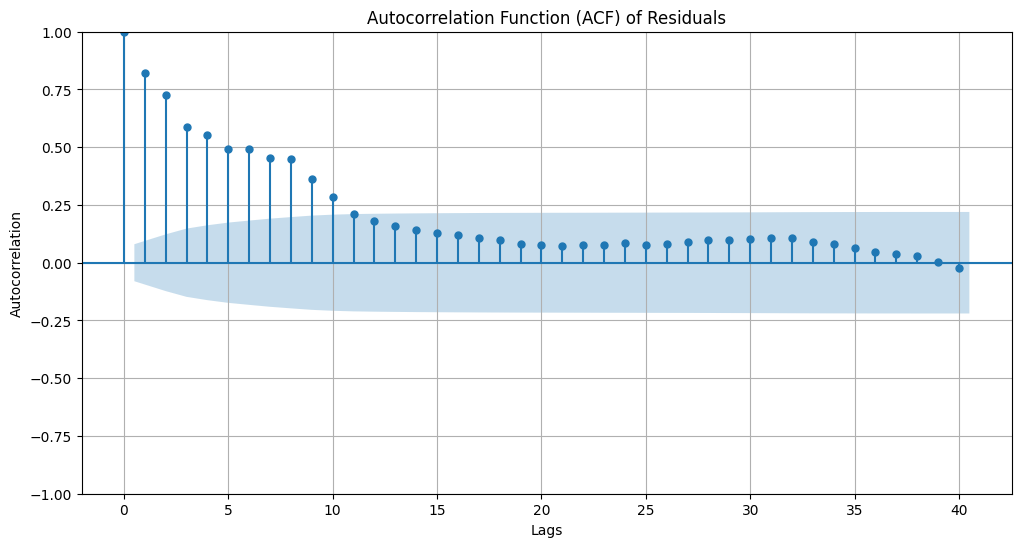

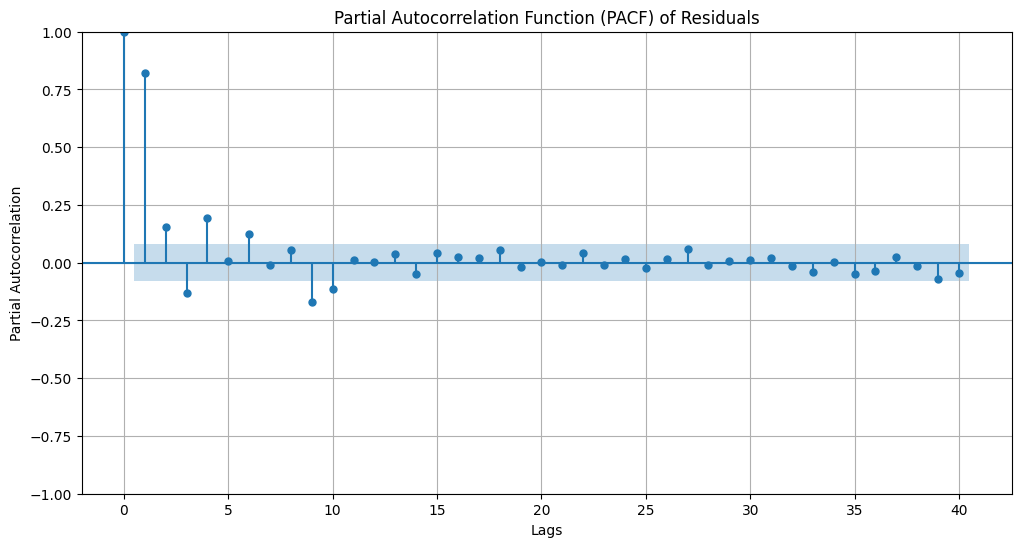

In [16]:
# Plotting ACF
import numpy as np
residuals= np.array(res.resid.values)
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, ax=plt.gca(), title='Autocorrelation Function (ACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

#Plotting PACF
plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=40, ax=plt.gca(), title='Partial Autocorrelation Function (PACF) of Residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()


##  Interpretation of Residual ACF After STL Decomposition

### What the ACF Indicates:
- **Significant autocorrelation** in residuals suggests STL has **not fully captured** all the structure (especially trend or seasonality).
- Residuals should be approximately **white noise** if STL fully decomposed the time series — but yours are **not**.

---

###  What This Means for STL Decomposition:
- STL may have **underfit** the trend or seasonal component.
- This could be due to:
  - Incorrect seasonality period.
  - Complex or **non-constant seasonal patterns**.
  - Gradual **drift in seasonality** over time.



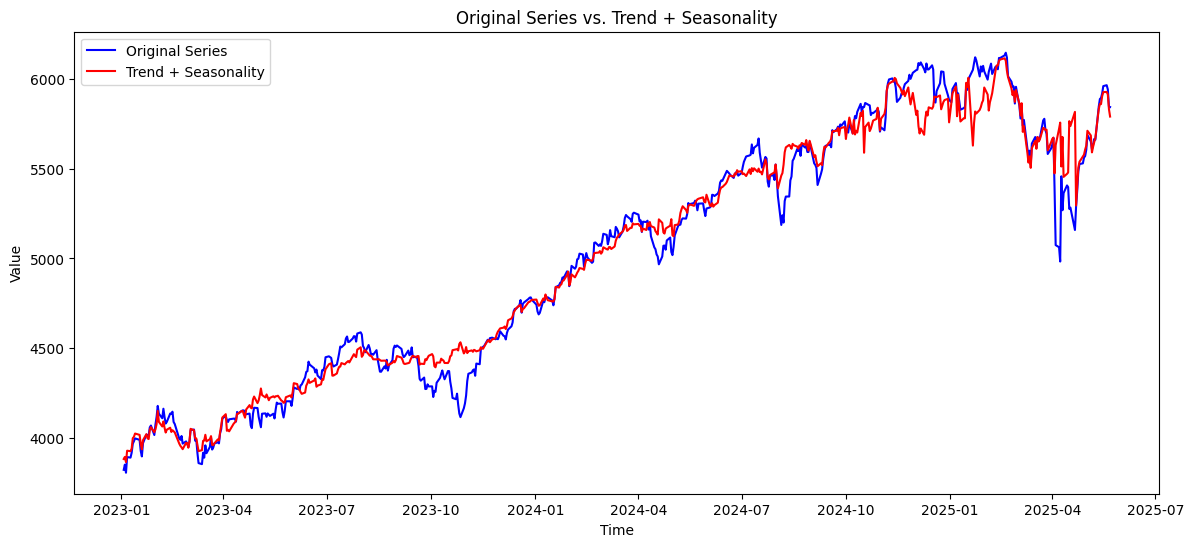

In [18]:
trend_seasonal = res.trend + res.seasonal

plt.figure(figsize=(14, 6))
plt.plot(sp500_df.index, sp500_df["Closing_Price"], label='Original Series', color='blue')
plt.plot(sp500_df.index, trend_seasonal, label='Trend + Seasonality', color='red')
plt.title('Original Series vs. Trend + Seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [21]:
#Adf test for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(sp500_df["Closing_Price"].dropna() )
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

ADF Statistic: -1.146077717663295
p-value: 0.6963514414883566
Critical Values: {'1%': -3.441406876071572, '5%': -2.866418015869717, '10%': -2.5693678601956718}
The time seriess is Non_Stationary


We will create a new column called log returns
The 'log_returns' column tells us, for each day, the continuously compounded percentage change in the closing price compared to the previous day. 


**How to Interpret Log Returns:**

- Positive log return: The stock price increased from the previous day.

- Negative log return: The stock price decreased from the previous day.

**Value meaning:**
- A log return of 0.01 means the price increased by about 1% (on a continuously compounded basis).
- A log return of -0.02 means the price decreased by about 2%.
- For small values, we can interpret them roughly as percentage changes.


****Why Use Log Returns?****

- ***Statistical Properties***: Log returns are more likely to be normally distributed, which is a key assumption for many statistical and econometric models used in TSA.

- ***Compounding and Additivity:*** Log returns are time-additive, meaning you can sum log returns over multiple periods to get the total log return over that period. This property simplifies modeling and forecasting.

- ***Handling of Volatility:*** Log returns better accommodate the compounding nature of returns and are less affected by large price swings, making them more robust for modeling volatility and other time series properties.

- ***Stationarity:*** While taking logs alone does not guarantee stationarity, the series of log returns (i.e., first differences of log prices) is often much closer to stationary than the raw price series, which is a requirement for most TSA techniques

In [22]:

#This formula computes the natural logarithm of the ratio of each day's closing price to the previous day's closing price, which is the standard method for calculating log returns in financial analysis. 
# The result will be a new column where each entry (except the first, which will be NaN) represents the daily log return for that date.
sp500_df['Log_return'] = np.log(sp500_df['Closing_Price'] / sp500_df['Closing_Price'].shift(1))
sp500_df.head()

,Closing_Price,Log_return
Date,,
2023-01-03,3824.139893,NaN
2023-01-04,3852.969971,0.007511
2023-01-05,3808.100098,-0.011714
2023-01-06,3895.080078,0.022584
2023-01-09,3892.090088,-0.000768


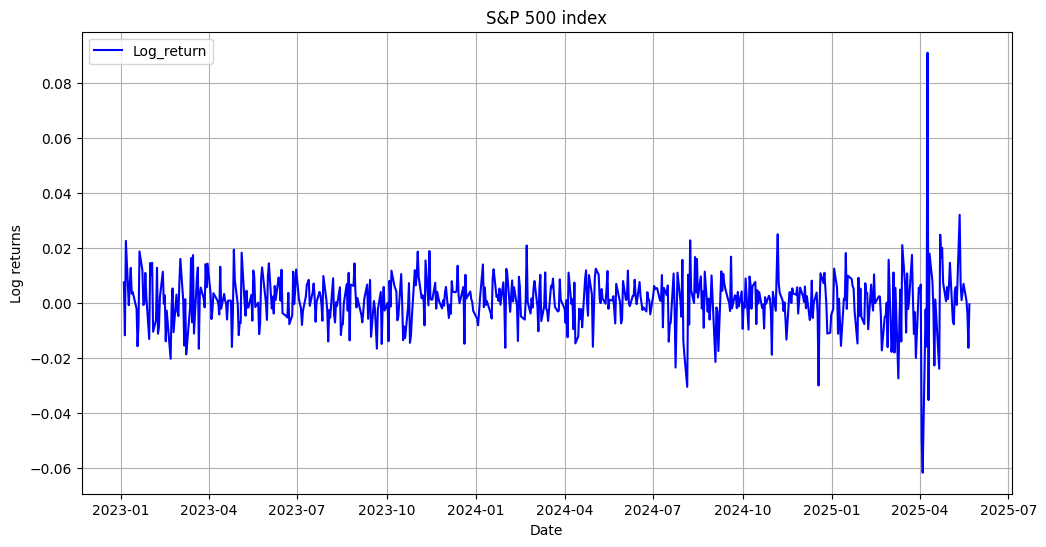

In [23]:
#plot Date vs Log_return

plot_timeseries(sp500_df,"Date","Log returns","Log_return")


- **Observation:**
The Log_return seems to have no trend at all however the comments on seasonality and varinace remain the same

Skewness: nan
Kurtosis: nan


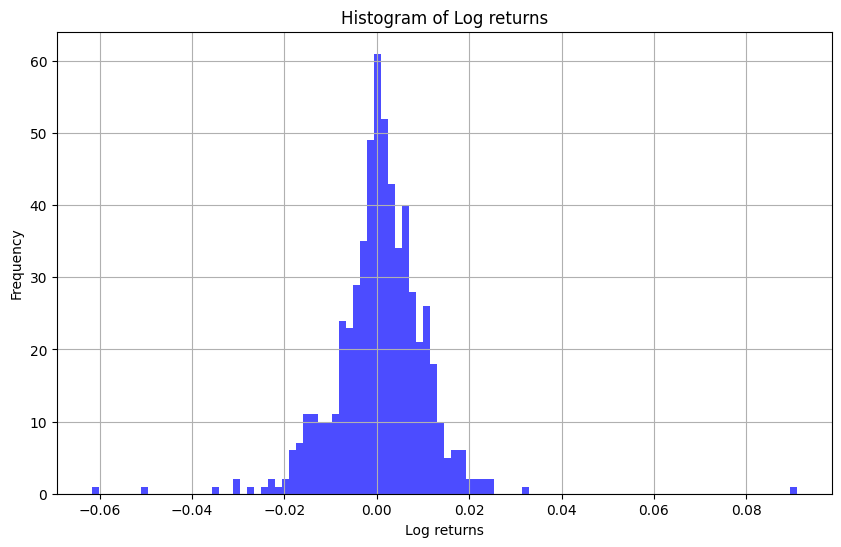

In [24]:

#have a check on the skewness of log_returns column

from scipy.stats import skew, kurtosis

skewness = skew(sp500_df["Log_return"])
kurt = kurtosis(sp500_df["Log_return"])
print("Skewness:", skewness) 
print("Kurtosis:", kurt)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sp500_df["Log_return"], bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Log returns")
plt.xlabel("Log returns")
plt.ylabel("Frequency")        
plt.grid(True)         
plt.show()    




- The  Log_reeturn data is almost normally distributed 

**Perform some checks on trend and seasonlaity.**

In [25]:
"""
Mann-Kendall test for presence of monotonic trend
A monotonic  trend means that the variable consistently increases  or decreases through time, but the trend may or may not be linear
The trend does not have to be a straight line; it just must not change direction (no reversals from increasing to decreasing or vice versa)
"""


"""
What Does the Mann-Kendall (pymannkendall) Test Do?
It tests the null hypothesis that there is no trend in the data.
The alternative hypothesis is that a monotonic trend (either increasing or decreasing) exists.
It is non-parametric: it does not assume any particular data distribution.
It is not designed to detect non-monotonic trends (such as cyclical, periodic, or trends that change direction)

"""



import pymannkendall as mk
 

result = mk.original_test(sp500_df["Log_return"].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.8849837323061163, z=-0.1446544146826225, Tau=-0.003960717747040666, s=-707.0, var_s=23820233.666666668, slope=-2.6963061137798295e-07, intercept=0.001022766987220373)


## Key Results and Interpretation

- **trend='no trend'**
There is no significant monotonic trend (neither increasing nor decreasing) .

- **h=False**
The test failed to reject the null hypothesis. In other words, there is not enough evidence to say a trend exists.

- **p=0.8771**
A p-value much greater than 0.05 means the result is not statistically significant.
The  p-value (0.877) is very high, confirming there is no significant trend.

- **z=-0.1546**
This is the standardized test statistic.
Values close to 0 indicate no trend.


In [26]:
#test for presence of linear trend

import statsmodels.api as sm  #sm= statsmodel for stattistical analysis
sp500_df["Log_return"].dropna()

#Create a time index array (0, 1, 2, ..., N-1) corresponding to each non-NaN log return
time_index = np.arange(len(sp500_df["Log_return"].dropna()))

x = sm.add_constant(time_index) 

# Fit an Ordinary Least Squares (OLS) linear regression model: y = intercept + slope * time_index
y = sp500_df["Log_return"].dropna().values
model = sm.OLS(y, x).fit()

#This Prints the regression results summary, including coefficients, R-squared, p-values, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4518
Date:                Wed, 04 Jun 2025   Prob (F-statistic):              0.502
Time:                        10:57:56   Log-Likelihood:                 1904.4
No. Observations:                 598   AIC:                            -3805.
Df Residuals:                     596   BIC:                            -3796.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.446      0.1


## Key Results and Interpretation

- **No Significant Trend Detected:**  
  The slope coefficient is **-1.42e-06** (p = **0.545**), which is extremely close to zero and not statistically significant. This means there is no evidence of an upward or downward trend in log returns over time.

- **Model Explains Almost Nothing:**  
  The **R-squared is 0.001**, so the time trend explains only 0.1% of the variation in log returns—essentially none.

- **Average Log Return Not Significant:**  
  The intercept (average daily log return) is **0.0012** (p = **0.159**), which is not statistically different from zero.

- **Overall Model Not Significant:**  
  The F-statistic is **0.3672** with a p-value of **0.545**, confirming the model does not significantly explain the data.



In [27]:
# Perform individual test for presence of seasonality

"""
The Friedman test is commonly used as a non-parametric test for detecting seasonality by comparing the medians of groups (such as months or quarters) across years.

The null hypothesis is that all periods (e.g., months) come from populations with equal medians—meaning there is no seasonality.

If the p-value is less than your significance level (commonly 0.05), you reject the null hypothesis and conclude that seasonality is present."""

from scipy.stats import friedmanchisquare

# Drop NaNs (e.g., from differencing)
values = sp500_df["Log_return"].dropna().values

# Ensure the length is divisible by 12 (e.g., complete years)
length = len(values) - (len(values) % 12)
values = values[:length]

# Reshape to (n_years, 12 months)
data = values.reshape(-1, 12)

# Apply Friedman test across columns (months)
stat, p = friedmanchisquare(*data.T)
print(f"Friedman p-value: {p:.6f}")  

# If p-value < 0.05, reject the null hypothesis of equal distributions across months
if p < 0.05:
    print("There are significant differences in the distributions of electric production across months, Means Seasonality exists.")   
else:
    print("No significant differences in the distributions of electric production across months, Seasonality does not exist.")

Friedman p-value: 0.302451
No significant differences in the distributions of electric production across months, Seasonality does not exist.



- Since 0.240053 > 0.05 we fail to reject null hypothesis 

- No significant seasonality detected:
- The differences between periods (months, quarters, etc.) are not large enough to be considered statistically significant.

- Interpretation:
Any apparent seasonal pattern in the  data could be due to random variation rather than a true, stable seasonal effect
Any observed differences could be due to random variation rather than a systematic effect.

In [28]:
#Perform ADF test for stationarity on log returns
from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(sp500_df["Log_return"].dropna() )
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

ADF Statistic: -13.841861926153314
p-value: 7.26775490032826e-26
Critical Values: {'1%': -3.441406876071572, '5%': -2.866418015869717, '10%': -2.5693678601956718}
THe result is stationary


- From the above results it might seem the data is stationary in mean (NO trend, No significant Seasonal Pattern)
- Lets now havea check on variance/std deviaition saperately.

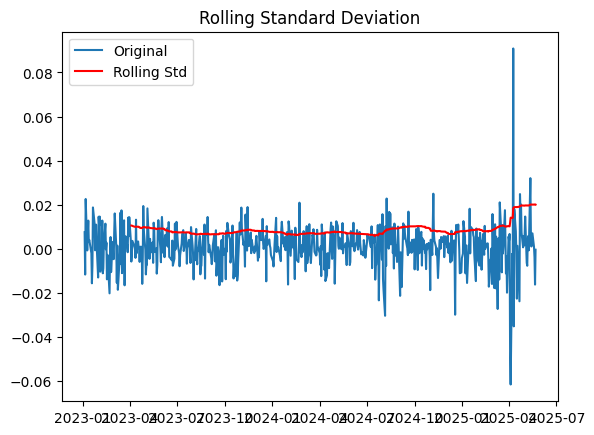

In [29]:
#checking for variance
def plot_rollingstd(df: pd.DataFrame):
    
        rolling_std = df["Log_return"].rolling(window=63).std()
        plt.plot(df["Log_return"], label='Original')
        plt.plot(rolling_std, label='Rolling Std', color='red')
        plt.legend()
        plt.title("Rolling Standard Deviation")
        plt.show() 

plot_rollingstd(sp500_df)


# Variance Analysis and Evidence of Heteroscedasticity

- **Rolling Standard Deviation:**  
  The graph of rolling standard deviation shows that variance (or standard deviation) is not constant over time.

- **Interpretation:**  
  While a non-constant rolling standard deviation suggests changing volatility, it alone does not conclusively prove heteroscedasticity.

- **Supporting Evidence from Residuals:**  
  Residual analysis from seasonal decomposition provides stronger evidence of heteroscedasticity, as the residuals display periods of increased volatility and changing variance.

- **Conclusion:**  
  Both the rolling standard deviation and residual analysis indicate that heteroscedasticity is likely present in the data, warranting the use of models that can account for time-varying volatility, such as GARCH.


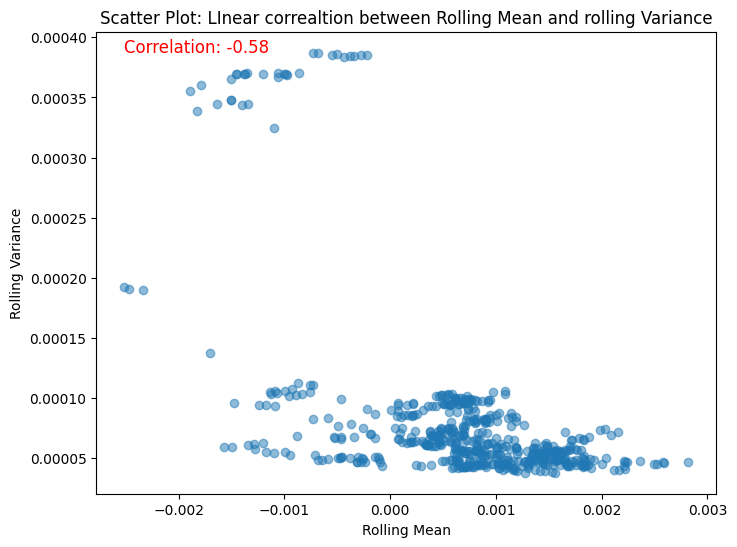

In [30]:
import matplotlib.pyplot as plt
import numpy as np
def plot_corr(df):
            # Calculate rolling mean and variance
            rolling_mean = df["Log_return"].rolling(window=66).mean()
            rolling_var = df["Log_return"].rolling(window=66).var()

            # Drop NaN values resulting from rolling calculationszzzzzz
            rolling_mean = rolling_mean.dropna()
            rolling_var = rolling_var.dropna()

            # Scatter plot
            plt.figure(figsize=(8,6))
            plt.scatter(rolling_mean, rolling_var, alpha=0.5)
            plt.xlabel('Rolling Mean')
            plt.ylabel('Rolling Variance')
            plt.title('Scatter Plot: LInear correaltion between Rolling Mean and rolling Variance')

            # Calculate correlation coefficient
            corr = np.corrcoef(rolling_mean, rolling_var)[0,1]

            # Display correlation coefficient on the plot
            plt.text(min(rolling_mean), max(rolling_var), f'Correlation: {corr:.2f}', fontsize=12, color='red')
            plt.show()
plot_corr(sp500_df)



# Negative Correlation Between Rolling Mean and Rolling Std Deviation

- The **-0.5 correlation** between rolling mean and rolling standard deviation suggests that periods with higher average values tend to have lower variability, and vice versa.
- Since variance (standard deviation) is not constant, this negative correlation indicates that **some of the changes in variance are associated with changes in the mean** over time.
- If the mean were to stabilize (become more constant), it is likely that some of the fluctuations in the rolling standard deviation would also decrease, leading to more stable variance.
- Thus inconsistent mean levels can contribute to instability in variance, and stabilizing the mean may help reduce volatility (or variability) in data.


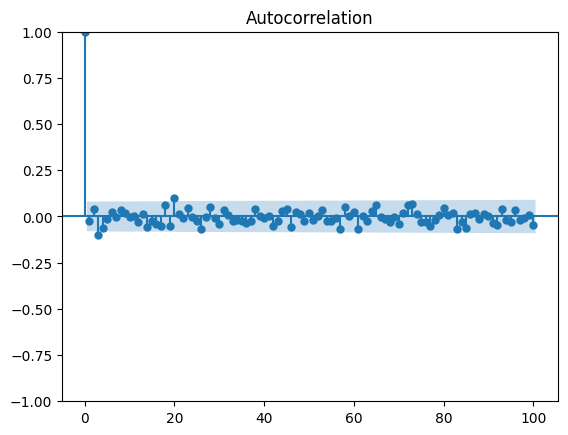

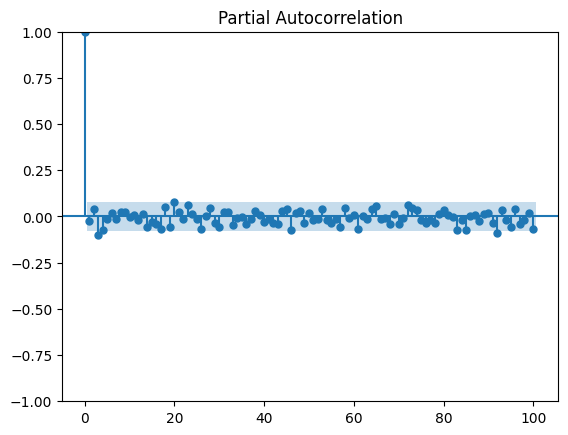

In [34]:

#Lets check the ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(df: pd.DataFrame):
            plot_acf(df["Log_return"].dropna(), lags=100)
            plot_pacf(df["Log_return"].dropna(), lags=100)
            plt.show()

plot_acf_pacf(sp500_df)





# Interpretation of Log Return ACF Results

- **All lags lie within the confidence interval:**  
  There is no significant autocorrelation at any lag in the log returns.

- **No linear autocorrelation:**  
  Past returns do not predict future returns in a linear way.

- **Implication for Market Efficiency:**  
  This is consistent with the **efficient market hypothesis (EMH)**, particularly the **weak form**, which states that all past price information is already reflected in current prices, making technical analysis ineffective.

- **Random Walk Behavior:**  
  The series may follow a random walk, where the best forecast for the next value is simply the last observed value.

> **COnclusion:**  
> No autocorrelation in log returns suggests the market is weak-form efficient, and future returns are unpredictable based on past returns.


# Implications for Modeling and Next Steps

- **No autocorrelation detected:**  
  There is no linear structure in the log returns, so ARIMA/SARIMA models are not suitable.
    - AR terms (e.g., AR(1)) will be statistically insignificant.
    - MA terms will also lack significance unless there is nonlinear dependence in the residuals.

- **Focus shifts to volatility modeling:**  
  Since financial returns often exhibit volatility clustering and changing variance (heteroskedasticity), we will model the conditional variance using GARCH-type models



In [35]:
"""
ARCH Test (Autoregressive Conditional Heteroskedasticity Test)

The ARCH test is a statistical test used to detect the presence of autoregressive conditional heteroskedasticity (ARCH) effects in a time series. 
ARCH effects indicate that the variance of the current error term or innovation is related to the variances of previous time periods' error terms, 
which is common in financial and economic time series.

How it works:
- The test fits a regression model to the squared residuals of a time series.
- It checks whether past squared residuals can explain the current squared residual.
- If the test statistic is significant (low p-value), it suggests the presence of ARCH effects (time-varying volatility).

Use case:
- The ARCH test is commonly used before fitting GARCH or other volatility models to determine if modeling conditional heteroskedasticity is necessary.

Hypotheses:
- Null Hypothesis (H0): No ARCH effects (homoskedasticity; constant variance).
- Alternative Hypothesis (H1): Presence of ARCH effects (heteroskedasticity; time-varying variance).
Interpretation:
- A p-value less than the chosen significance level (e.g., 0.05) indicates rejection of the null hypothesis, suggesting the presence of ARCH effects.
"""


# ARCH test
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(sp500_df["Log_return"].dropna())
if arch_test[1]<0.05: 
    print("Arch effects present")
else:
    print("Arch effects not present")

print("P-value: ", arch_test[1])

Arch effects present
P-value:  1.4630605908797108e-19


> Modeling volatility with GARCH means forecasting how the variance of returns changes over time, based on past shocks and past volatility. The key result from GARCH is a time series of conditional volatility estimates, which are critical for understanding and managing risk in financial markets

In [36]:
""" 
Coefficients:

mu: This is the constant term in the mean equation (if you included one). It represents the average value of the series.
omega: This is the constant term in the variance equation. It's the long-run average variance. It must be positive.
alpha[1]: This is the coefficient on the lagged squared residual (the ARCH term). It indicates how much the previous period's shock affects current volatility. It should be positive and less than 1.
beta[1]: This is the coefficient on the lagged conditional variance (the GARCH term). It indicates how much the previous period's volatility affects current volatility. It should be positive and less than 1.
alpha[1] + beta[1]: The sum of these coefficients is crucial. If it's close to 1, it suggests that volatility is very persistent (it takes a long time for shocks to die out). If it's greater than or equal to 1, the model is not stationary, which is a problem.
Significance (P-values):

Look at the p-values associated with each coefficient. A small p-value (typically less than 0.05) indicates that the coefficient is statistically significant, meaning it's unlikely to be zero. Significant coefficients are important for the model.
Model Fit Statistics:

Log-Likelihood: A higher log-likelihood generally indicates a better fit.
AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These are used to compare different models. Lower values indicate a better trade-off between model fit and complexity. If you're comparing different GARCH models (e.g., different orders), use these to help choose the best one.
Diagnostics:

Jarque-Bera Test: This tests whether the residuals are normally distributed. GARCH models assume that the standardized residuals (residuals divided by the conditional standard deviation) are normally distributed. A significant p-value here suggests non-normality, which might indicate a problem with the model or the need for a different distribution.
Ljung-Box Test: This tests for autocorrelation in the residuals and squared residuals. Significant autocorrelation suggests that the model is not capturing all the dependence in the data. If there is autocorrelation in the squared residuals, it suggests that there is still ARCH effect in the residuals, and the model is not correctly specified.
Warnings:

Pay attention to any warnings that the arch library might produce. These warnings can indicate potential problems with the model, such as non-stationarity or convergence issues.
In summary, you're looking for: significant coefficients that make sense in the context of your data, a good model fit (as indicated by the AIC/BIC), and no major violations of the model's assumptions (as indicated by the diagnostic tests).

"""



from arch import arch_model

series =sp500_df["Log_return"].dropna()


# Fit GARCH(1,1)
model = arch_model(series, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1975.64
Distribution:                  Normal   AIC:                          -3943.28
Method:            Maximum Likelihood   BIC:                          -3925.71
                                        No. Observations:                  598
Date:                Wed, Jun 04 2025   Df Residuals:                      597
Time:                        11:05:48   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.6866e-04  1.100e-04      7.895  2.907e-15 [6.

i:\CQAI\TSA\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001004. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# GARCH Model Results

## Mean Model
- **mu (mean return):** 0.0008687 (significant, p < 0.001)  
  The average log return is positive but very close to zero, consistent with typical financial return behavior.
- **R-squared:** 0.000 — The mean model explains virtually none of the variation in returns, indicating returns are essentially unpredictable in mean.

## Volatility Model (GARCH(1,1))
- **omega (constant term):** 2.0124e-06 (highly significant)  
  Baseline level of volatility.
- **alpha[1] (ARCH term):** 0.10 (significant, p ≈ 0.008)  
  Indicates that recent shocks (squared returns) have a moderate effect on current volatility.
- **beta[1] (GARCH term):** 0.88 (highly significant, p ≈ 0)  
  Suggests strong persistence in volatility; past volatility heavily influences current volatility.
- **Sum of alpha and beta:** 0.98, close to 1 — implies high volatility persistence and slow decay of shocks.

## Model Fit
- **Log-Likelihood:** 1975.64  (A higher value indicates a better fit to the data, given the model.)
- **AIC:** -3943.28, **BIC:** -3925.71 — these values indicate model quality (lower is better).
- **Number of Observations:** 598 (adequate sample size for estimation)

---

### Key insights::
- The mean return is small but statistically significant.
- Volatility is highly persistent, with recent shocks and past volatility strongly influencing current volatility.
- The GARCH(1,1) model effectively captures the time-varying nature of volatility in the log returns.
 - To confirm it is the best model, we can compare its AIC/BIC to alternative models.
